In [ ]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [2]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [9]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [10]:
# !pip install moviepy

In [11]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
label_map = {label:num for num, label in enumerate(actions)}

In [14]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [15]:
DATA_PATH

'data2'

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(450, 30, 1662)

In [18]:
np.array(labels).shape

(450,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(450, 30, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_test.shape

(23, 6)

## Build Network

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [51]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [52]:
import tensorflow as tf

In [53]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
        # Calculate attention scores using scalar dot product
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        
        average_attention_score = tf.reduce_mean(attention_scores)
        
        return output, attention_scores, average_attention_score

In [54]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores, average_attention_score = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [55]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
average_attention_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.033333335>

In [24]:
def Reward(y_true, y_pred, external_metric, attention_scores):
    # Component 1: Correct Predictions with dynamic scaling and regularization
    correct_predictions = tf.reduce_sum(y_true * y_pred) * (1 + tf.math.log1p(external_metric)) / (1 + tf.math.exp(-tf.reduce_mean(y_pred)))

    # Component 2: Diversity Penalty with attention score influence and temporal smoothing
    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2) * (1 - tf.reduce_mean(attention_scores)) * tf.math.exp(-tf.reduce_mean(y_pred))

    # Component 3: Weighted Mistakes Penalty with attention score modulation and class-specific regularization
    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.3, 1.5]) * attention_scores * tf.math.log1p(tf.reduce_sum(y_true, axis=0)))

    # Component 4: External Metric Bonus with exponential boost and regularization
    external_metric_bonus = 0.4 * tf.math.exp(external_metric) / (1 + tf.math.exp(-tf.reduce_mean(y_pred)))

    # Component 5: Average Attention Score Term with temporal smoothing and scaling
    average_attention_score = tf.sqrt(tf.reduce_mean(attention_scores)) * tf.math.log1p(tf.reduce_mean(y_pred))

    # Component 6: Novel Term incorporating external metric, attention scores, and class-specific regularization
    novel_term = 0.2 * external_metric * tf.math.exp(-tf.reduce_mean(y_pred)) + 0.3 * tf.reduce_mean(tf.square(attention_scores) * tf.math.log1p(tf.reduce_sum(y_true, axis=0)))

    # Component 7: Temporal Regularization Term
    temporal_regularization = tf.math.exp(-tf.reduce_mean(y_pred))

    # Component 8: Spatial Regularization Term
    spatial_regularization = tf.math.exp(-tf.norm(mean_pred_axis_0, ord=2))

    # Combined Reward with additional regularization terms
    reward = correct_predictions - 0.1 * diversity_penalty - 0.3 * weighted_mistakes_penalty + external_metric_bonus + 0.2 * average_attention_score + novel_term + temporal_regularization + spatial_regularization

    return reward


In [25]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    
    _, _, average_attention_score = attention_layer(y_pred, y_pred, y_pred)
    
    external_metric = 0.5
    
    reward = Reward(y_true, y_pred, external_metric, average_attention_score)
    
    return loss - 0.1 * reward

In [58]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [59]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [60]:
X_train.shape,y_train.shape

((427, 30, 1662), (427, 6))

In [61]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
14/14 [==============================] - 29s 314ms/step - loss: 2.4198 - categorical_accuracy: 0.2014
Epoch 2/100
14/14 [==============================] - 5s 323ms/step - loss: 1.3950 - categorical_accuracy: 0.1546
Epoch 3/100
14/14 [==============================] - 4s 313ms/step - loss: 1.4629 - categorical_accuracy: 0.1710
Epoch 4/100
14/14 [==============================] - 3s 213ms/step - loss: 1.1266 - categorical_accuracy: 0.2740
Epoch 5/100
14/14 [==============================] - 2s 175ms/step - loss: 1.0061 - categorical_accuracy: 0.3162
Epoch 6/100
14/14 [==============================] - 3s 184ms/step - loss: 1.2665 - categorical_accuracy: 0.2693
Epoch 7/100
14/14 [==============================] - 3s 182ms/step - loss: 1.3500 - categorical_accuracy: 0.2155
Epoch 8/100
14/14 [==============================] - 3s 195ms/step - loss: 1.2276 - categorical_accuracy: 0.2646
Epoch 9/100
14/14 [==============================] - 3s 198ms/step - loss: 0.8789 - categorical

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 128)           916992    
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


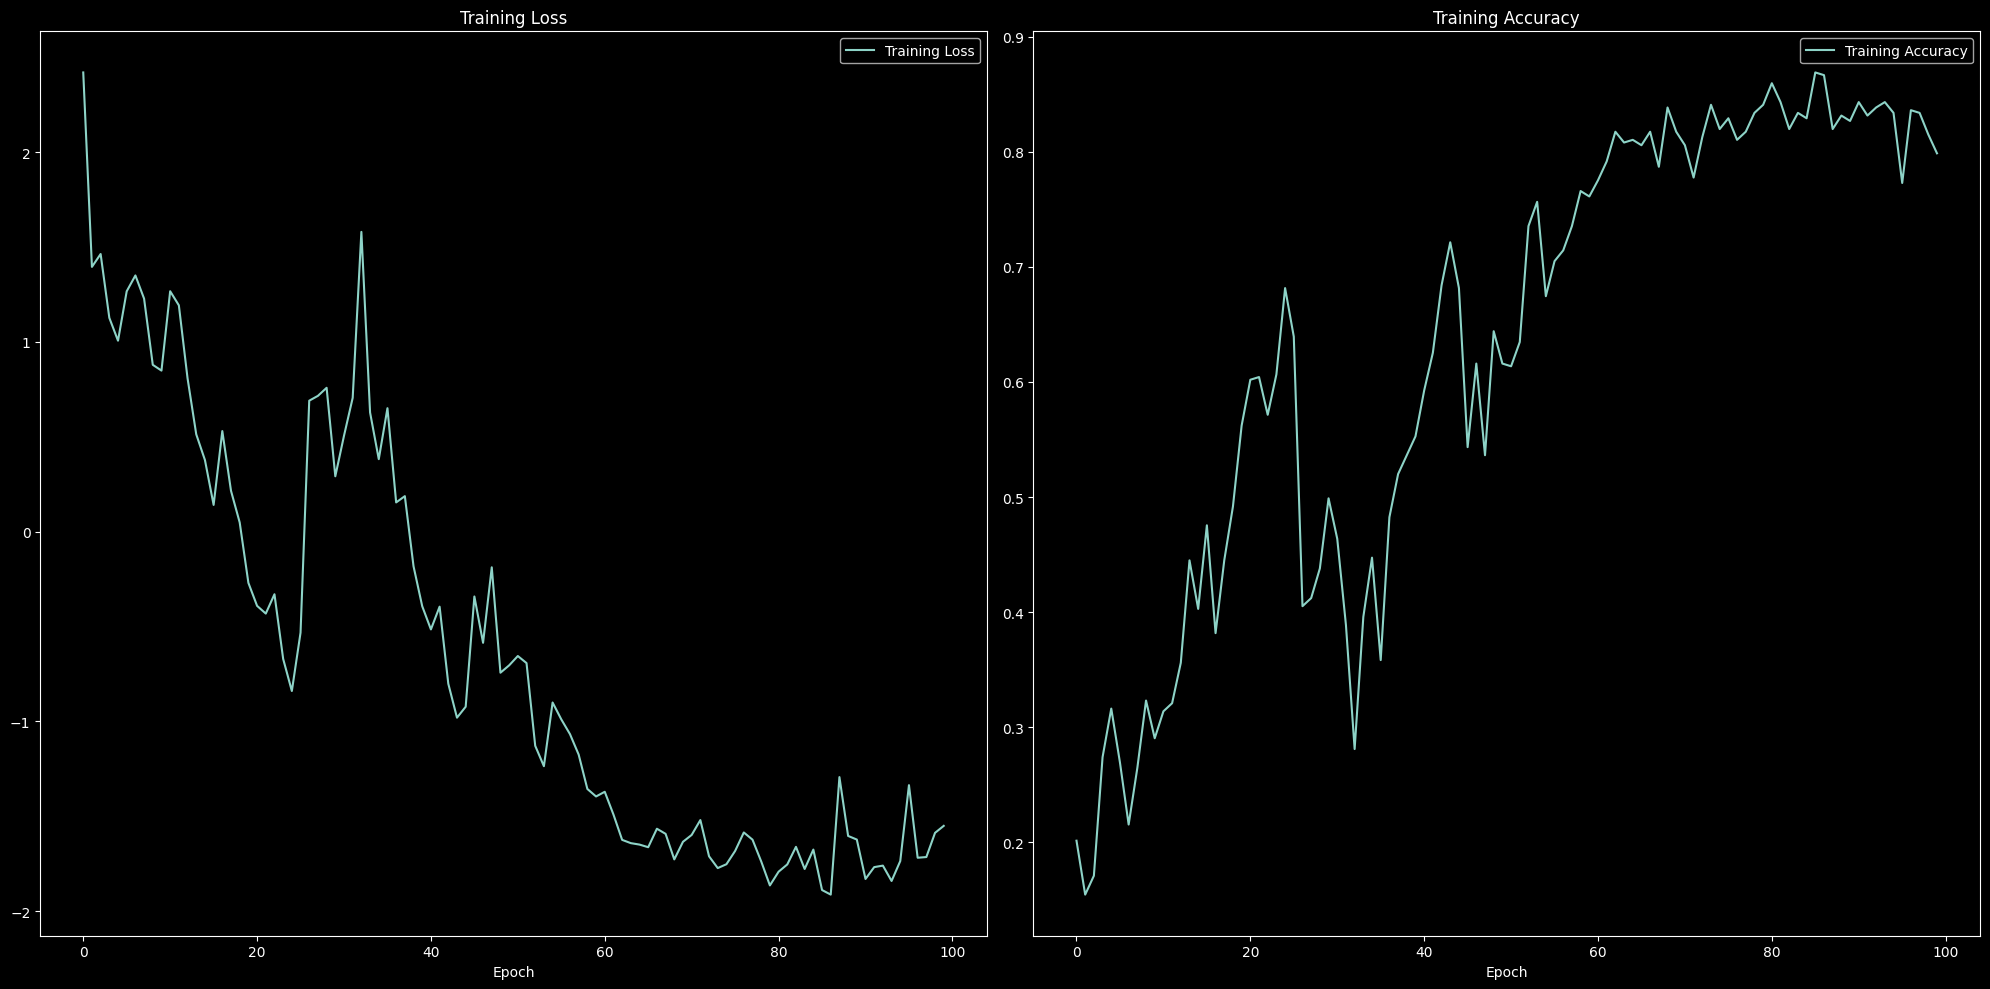

In [63]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
y_p = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [65]:
y_p.shape

(23, 6)

In [66]:
y_test.shape

(23, 6)

In [67]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [68]:
# calculate_reward(y_test,y_p)

In [69]:
res = model.predict(X_test)

1/1 [==============================] - 0s 90ms/step


In [70]:
X_test

array([[[ 0.60634059,  0.55491072, -1.04024255, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60117257,  0.55490822, -1.0157721 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.59768188,  0.55494666, -1.03387845, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.60330266,  0.54476851, -1.28660083, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60203284,  0.54442257, -1.149984  , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60027808,  0.54426688, -1.0694108 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.60645151,  0.61626238, -1.15339303, ...,  0.52011323,
          0.26790157, -0.10483942],
        [ 0.60764229,  0.6159302 , -1.16599894, ...,  0.52408683,
          0.28885972, -0.11469182],
        [ 0.60876948,  0.64212555, -1.16197801, ...,  0.53268039,
          0.31843147, -0.12967503],
        ...,
        [ 0.6256153 ,  0.67288744, -1.43679106, ...,  

In [71]:
res

array([[3.01950308e-03, 5.70110194e-02, 1.64286257e-03, 1.25983963e-04,
        9.31971669e-01, 6.22887211e-03],
       [3.02615482e-03, 1.08775003e-02, 9.21429601e-03, 5.10664599e-04,
        9.73496556e-01, 2.87495507e-03],
       [4.06307699e-05, 7.84772146e-06, 9.38782454e-01, 7.75963344e-05,
        1.02542501e-04, 6.09889403e-02],
       [9.91627693e-01, 8.90795945e-07, 2.59989128e-03, 5.65112615e-03,
        1.20346216e-04, 3.77457710e-09],
       [1.22396887e-05, 8.95568704e-08, 9.95373547e-01, 1.06262405e-05,
        5.29107638e-06, 4.59828274e-03],
       [2.64513493e-01, 5.16120708e-05, 3.30450460e-02, 7.02002525e-01,
        3.70346010e-04, 1.69485538e-05],
       [2.26140855e-06, 2.08883488e-09, 4.93533980e-06, 2.11330287e-10,
        1.16718919e-08, 9.99992847e-01],
       [9.99367893e-01, 3.13519592e-11, 1.37990632e-04, 1.49215467e-07,
        3.07839834e-08, 4.94066626e-04],
       [1.65684763e-02, 5.08962452e-01, 2.33847741e-02, 3.59982960e-02,
        3.65667701e-01, 

In [75]:
actions[np.argmax(res[6])]

'surprise'

In [74]:
actions[np.argmax(y_test[6])]

'surprise'

In [76]:
# model.save('action_with_Reward_5.h5')
# model.save_weights('action_with_Reward_5_weights.h5')

H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import tensorflow as tf

In [27]:
model = tf.keras.models.load_model("action_with_Reward_5.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [59]:
_, test1, _, test1_label = train_test_split(X, y, test_size=0.30)

In [60]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [61]:
yhat = model.predict(test1)

5/5 [==============================] - 0s 70ms/step


In [62]:
ytrue = np.argmax(test1_label, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [63]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[115,   1],
        [  0,  19]],

       [[ 97,  11],
        [  5,  22]],

       [[106,   8],
        [  3,  18]],

       [[109,   2],
        [  1,  23]],

       [[110,   2],
        [ 12,  11]],

       [[113,   1],
        [  4,  17]]], dtype=int64)

In [64]:
accuracy_score(ytrue, yhat)

0.8148148148148148

In [84]:
for num, prob in enumerate(res):
    print(num,prob)

0 [3.0195031e-03 5.7011019e-02 1.6428626e-03 1.2598396e-04 9.3197167e-01
 6.2288721e-03]
1 [3.0261548e-03 1.0877500e-02 9.2142960e-03 5.1066460e-04 9.7349656e-01
 2.8749551e-03]
2 [4.0630770e-05 7.8477215e-06 9.3878245e-01 7.7596334e-05 1.0254250e-04
 6.0988940e-02]
3 [9.91627693e-01 8.90795945e-07 2.59989128e-03 5.65112615e-03
 1.20346216e-04 3.77457710e-09]
4 [1.22396887e-05 8.95568704e-08 9.95373547e-01 1.06262405e-05
 5.29107638e-06 4.59828274e-03]
5 [2.6451349e-01 5.1612071e-05 3.3045046e-02 7.0200253e-01 3.7034601e-04
 1.6948554e-05]
6 [2.2614086e-06 2.0888349e-09 4.9353398e-06 2.1133029e-10 1.1671892e-08
 9.9999285e-01]
7 [9.9936789e-01 3.1351959e-11 1.3799063e-04 1.4921547e-07 3.0783983e-08
 4.9406663e-04]
8 [0.01656848 0.50896245 0.02338477 0.0359983  0.3656677  0.04941834]
9 [6.7921588e-05 7.9702389e-01 1.5577711e-01 1.6070050e-03 1.5716836e-02
 2.9807186e-02]
10 [9.9814117e-01 7.1547124e-10 8.8424660e-04 8.2116264e-07 3.8142261e-07
 9.7346527e-04]
11 [0.00100467 0.5271275  0

In [85]:
from scipy import stats

In [86]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        probability_text = f"{prob * 100:.4f}"  # Format probability to display up to 4 decimal points
        label_text = actions[num]
        cv2.putText(output_frame, f"{label_text}: {probability_text}", (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [87]:
# prob_viz(res[0], actions, image, colors)

In [88]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [89]:
import tensorflow as tf

In [91]:
model = tf.keras.models.load_model("action_with_Reward_5.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [92]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("../happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

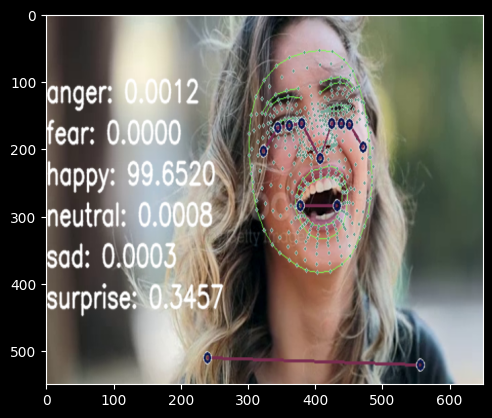

In [93]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [94]:
# history

In [95]:
res

array([1.1619531e-05, 5.2580258e-08, 9.9651968e-01, 8.2321221e-06,
       3.4011011e-06, 3.4570158e-03], dtype=float32)

In [96]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 1.1619531e-05
fear ----> 5.258026e-08
happy ----> 0.9965197
neutral ----> 8.232122e-06
sad ----> 3.4011011e-06
surprise ----> 0.0034570158


In [97]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 3 elements:", top_indices)

Indices of the top 3 elements: [2 5]


In [98]:
ans=[]

In [99]:
for i in top_indices:
    ans.append(actions[i])

In [100]:
ans

['happy', 'surprise']

In [101]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
                       # cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [102]:
res

array([0.00244456, 0.5239936 , 0.00437142, 0.00655857, 0.45052278,
       0.01210904], dtype=float32)

In [103]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 0.0024445613
fear ----> 0.5239936
happy ----> 0.0043714233
neutral ----> 0.0065585705
sad ----> 0.45052278
surprise ----> 0.012109045


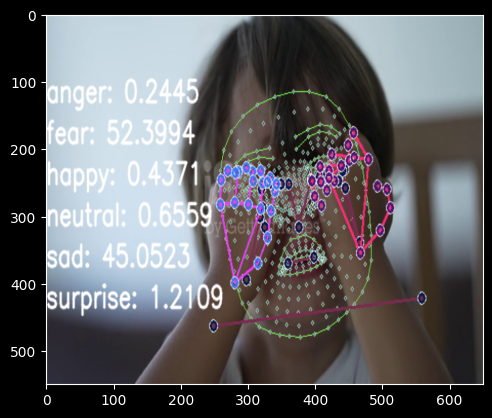

In [105]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [106]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("../fear20.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [107]:
res

array([6.4385204e-05, 9.2242330e-01, 4.3766364e-02, 1.2196749e-03,
       1.6102696e-02, 1.6423613e-02], dtype=float32)

In [108]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

anger ----> 6.438520358642563e-05
fear ----> 0.9224233031272888
happy ----> 0.043766364455223083
neutral ----> 0.0012196749448776245
sad ----> 0.01610269583761692
surprise ----> 0.01642361283302307


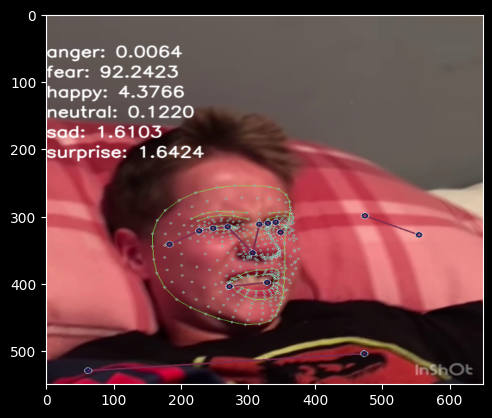

In [109]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()